In [43]:
import os
import ee
import geemap 
import pandas as pd

#ee.Authenticate()
ee.Initialize()

In [44]:
# Define the bounding box of Colombia (using a shapefile uploaded to the assets folder)
macarenaMpio = ee.FeatureCollection('projects/ee-juamiji/assets/Macarena_mpio')
macarenaAp = ee.FeatureCollection('projects/ee-juamiji/assets/Macarena_AP')

# Import the Forest loss image
flossHansen = ee.Image("UMD/hansen/global_forest_change_2019_v1_7")

# Import the Primary Tropical Forest cover image collection and filter it for Colombia
primaryForest_ideam = ee.Image("projects/ee-juamiji/assets/SouthAmerica_2001_primary").selfMask()
primaryForest_ideam_COL = primaryForest_ideam.clip(macarenaMpio)

# Clip the Forest loss image to Colombia's boundaries
flossHansen_COL = flossHansen.clip(macarenaMpio)

In [45]:
# Get the property names (column names) of the shapefile
first_feature = macarenaMpio.first().getInfo()
column_names = list(first_feature['properties'].keys())
print("Column names:", column_names)

Column names: ['AREA_KM2', 'CAR', 'COD_DANE_D', 'IDDANE', 'ID_ESPACIA', 'Join_Count', 'NMG', 'NOMBRE', 'OBJECTID', 'OBJECTID_1', 'Shape_Ar_1', 'Shape_Area', 'Shape_Leng', 'TARGET_FID']


In [46]:
# Create a mask where fcover is equal to 1.
primaryMask = primaryForest_ideam_COL.eq(1)

# Masking the floss imagery using the primary mask (cover equals 1)
flossHansen_COLmasked = flossHansen_COL.updateMask(primaryMask)

# Select the 'loss' band from the masked forest loss image
loss = flossHansen_COLmasked.select(['loss'])

In [47]:
lossVis = { 
    'min': 0,
    'max': 1,
    'palette': ['green', 'red']
}

# Create the map with a gray basemap
Map = geemap.Map(center=[4.0, -72.0], zoom=5)

# Add forest loss layer
Map.addLayer(loss, lossVis, 'Forest Loss in Primary Forests')

# Add polygons (borders only)
Map.addLayer(macarenaMpio.style(**{'color': 'black', 'fillColor': '00000000', 'width': 2}), {}, 'Macarena Mpio')
Map.addLayer(macarenaAp.style(**{'color': 'blue', 'fillColor': '00000000', 'width': 2}), {}, 'Macarena AP')

# Zoom to Macarena
Map.centerObject(macarenaMpio, 6)
Map


Map(center=[2.1538156093786425, -74.0782721817589], controls=(WidgetControl(options=['position', 'transparent_…

### NOTE: see the progress of exports at [GEE Task Manager](https://code.earthengine.google.com/tasks)

In [29]:
# Export to Google Drive
task = ee.batch.Export.image.toDrive(
    image=loss,
    description='loss_30m',  # name for the export task
    folder='EarthEngineExports',
    fileNamePrefix='loss_30m',
    region=macarenaMpio.geometry(),
    scale=30,
    maxPixels=1e13
)

task.start()

In [48]:
# Export to Google Drive
task = ee.batch.Export.image.toDrive(
    image=primaryForest_ideam_COL,
    description='fprimary_30m',  # name for the export task
    folder='EarthEngineExports',
    fileNamePrefix='fprimary_30m',
    region=macarenaMpio.geometry(),
    scale=30,
    maxPixels=1e13
)

task.start()

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties

import mapclassify

from rapidfuzz import process, fuzz

from shapely.geometry import Point

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterstats import zonal_stats
from glob import glob
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [2]:
# Set base project path
base_path = Path("C:/Users/juami/Dropbox/My-Research/Deforestation/data/Illegal Deforestation/Macarena")

In [3]:
# Read the shapefiles and CSV files
macarenaMpio = gpd.read_file(base_path / "Macarena_mpio.shp")

print(macarenaMpio.columns)

# Keep only relevant columns
macarenaMpio = macarenaMpio[["IDDANE", "geometry"]]

print(f"Number of features: {len(macarenaMpio)}") 

Index(['OBJECTID', 'NMG', 'AREA_KM2', 'ID_ESPACIA', 'COD_DANE_D', 'IDDANE',
       'OBJECTID_1', 'Join_Count', 'TARGET_FID', 'CAR', 'NOMBRE', 'Shape_Area',
       'Shape_Leng', 'Shape_Ar_1', 'geometry'],
      dtype='object')
Number of features: 1


In [4]:
# Read the shapefiles and CSV files
macarenaAp = gpd.read_file(base_path / "Macarena_Ap.shp")

print(macarenaAp.columns)

# Keep only relevant columns
macarenaAp = macarenaAp[["FID_Munici", "geometry"]]

print(f"Number of features: {len(macarenaAp)}")

Index(['FID_Munici', 'Municipios', 'Municipi_1', 'Municipi_2', 'Municipi_3',
       'Municipi_4', 'Municipi_5', 'Municipi_6', 'Municipi_7', 'Municipi_8',
       'Municipi_9', 'Municip_10', 'FID_runapr', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')
Number of features: 1


In [5]:
# open the raster
loss = rasterio.open(base_path / "loss_30m.tif")
fprimary = rasterio.open(base_path / "fprimary_30m.tif")

In [6]:
raster_crs = loss.crs
macarenaMpio = macarenaMpio.to_crs(raster_crs)
macarenaAp = macarenaAp.to_crs(raster_crs)

print("Loss CRS:", loss.crs)
print("macarenaMpio CRS:", macarenaMpio.crs)
print("macarenaAp CRS:", macarenaAp.crs)

Loss CRS: EPSG:4326
macarenaMpio CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
macarenaAp CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


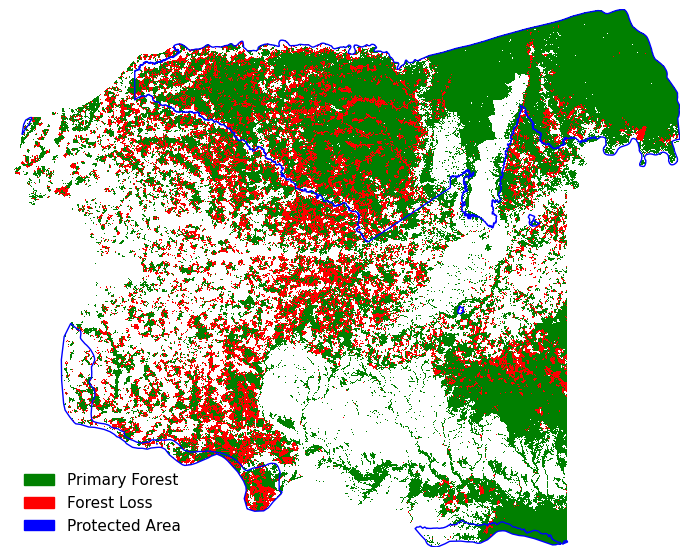

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Define colormaps
cmap_primary = ListedColormap(['none', 'green'])  # 0 = transparent, 1 = green
cmap_loss    = ListedColormap(['none', 'red'])    # 0 = transparent, 1 = red

# Get extents from rasters
f_bounds = fprimary.bounds
extent = (f_bounds.left, f_bounds.right, f_bounds.bottom, f_bounds.top)

fig, ax = plt.subplots(figsize=(7, 7))

# Plot rasters with correct extent
ax.imshow(fprimary.read(1), cmap=cmap_primary, interpolation="none",
          extent=extent, origin="upper")
ax.imshow(loss.read(1), cmap=cmap_loss, interpolation="none",
          extent=extent, origin="upper")

# Plot polygons (now should align)
macarenaAp.boundary.plot(ax=ax, edgecolor='blue', linewidth=1, label='Protected Area')
#macarenaMpio.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Legend
legend_patches = [
    mpatches.Patch(color='green', label='Primary Forest'),
    mpatches.Patch(color='red', label='Forest Loss'),
    mpatches.Patch(color='blue', label='Protected Area')
]
ax.legend(handles=legend_patches, frameon=False, loc='lower left', fontsize=11)

ax.set_axis_off()
plt.tight_layout()

plt.savefig(base_path / "floss_macarena.png", format="png", dpi=300, bbox_inches="tight")

plt.show()
